# Ornstein Uhlenbeck process


In [1]:
from dataclasses import dataclass
from typing import Optional, Union
import numpy as np
from sklearn.linear_model import LinearRegression
import brownian_motion


# ----------------------------------------------------------------
# Ornstein Uhlenbeck process


@dataclass
class OUParams:
    alpha: float  # mean reversion parameter
    gamma: float  # asymptotic mean
    beta: float  # Brownian motion scale (standard deviation)


(array([-0.01 , -0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,
         0.006,  0.008,  0.01 ]),
 [Text(0, -0.01, '−0.010'),
  Text(0, -0.008, '−0.008'),
  Text(0, -0.006, '−0.006'),
  Text(0, -0.004, '−0.004'),
  Text(0, -0.002, '−0.002'),
  Text(0, 0.0, '0.000'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.008000000000000002, '0.008'),
  Text(0, 0.01, '0.010')])

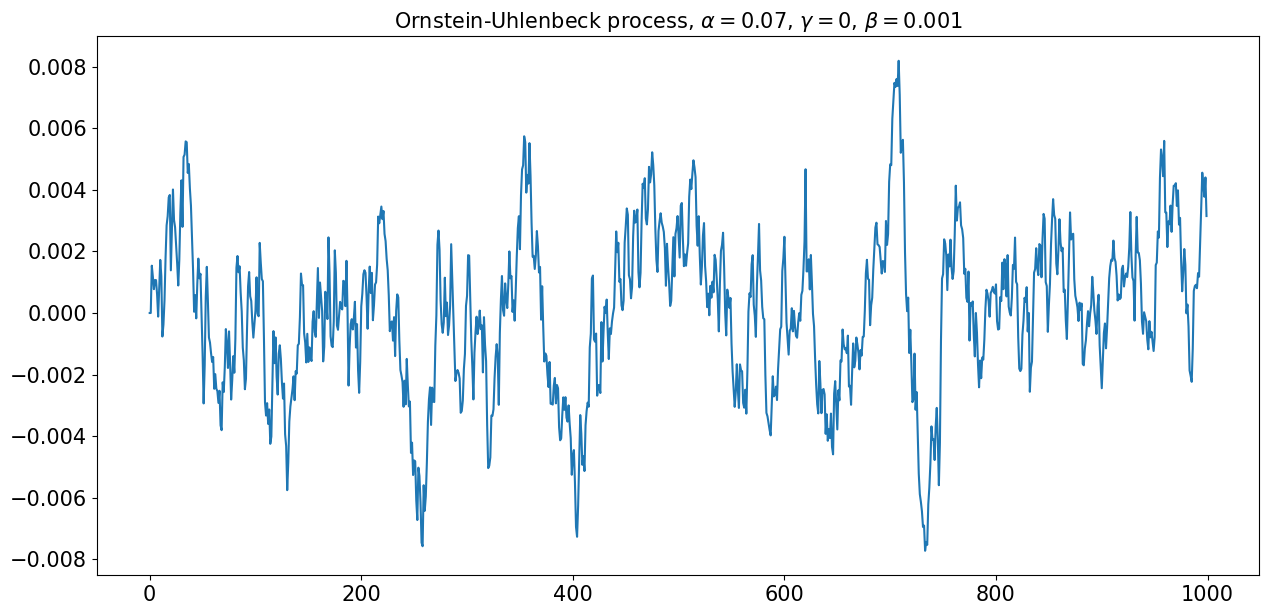

In [2]:
#import OU_proc
#from OU_proc import OUParams

OU_params = OUParams(alpha=0.07, gamma=0.0, beta=0.001)
OU_proc = get_OU_process(1_000, OU_params)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "Ornstein-Uhlenbeck process, "
title += r"$\alpha=0.07$, $\gamma = 0$, $\beta = 0.001$"
plt.plot(OU_proc)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [3]:
# generate process with random_state to reproduce results
OU_params = OUParams(alpha=0.07, gamma=0.1, beta=0.001)
OU_proc = get_OU_process(100_000, OU_params)

OU_params_hat = estimate_OU_params(OU_proc)



C:\Users\marti\AppData\Local\Temp\ipykernel_26068\3801253207.py:54: RuntimeWarning: overflow encountered in exp
  exp_alpha_s = np.exp(OU_params.alpha * t)
C:\Users\marti\AppData\Local\Temp\ipykernel_26068\3801253207.py:55: RuntimeWarning: overflow encountered in multiply
  integral_W = np.cumsum(exp_alpha_s * dW)
c:\Users\marti\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
c:\Users\marti\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
c:\Users\marti\anaconda3\lib\site-packages\numpy\lib\function_base.py:1447: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values